<a href="https://colab.research.google.com/github/VedPat/SynergyLabs-DeepLearning/blob/main/Synergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# data = files.upload()
from google.colab import drive
drive.mount('/content/drive')

# Download dataset
https://drive.google.com/file/d/1vao6Yx3Lb4fin5jqTYmdCZN8MmNmJ0ni/view?usp=sharing

In [ ]:
!rm -rf '/content/HorsevDog'
!unzip drive/"My Drive"/HorsevDog.zip

In [43]:
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
from google.colab import files
from keras.preprocessing import image

In [16]:
!rm -rf "/tmp/dataset/"
try:
  os.mkdir("/tmp/dataset/")
  os.mkdir("/tmp/dataset/train/")
  os.mkdir("/tmp/dataset/test/")
  os.mkdir("/tmp/dataset/train/horse/")
  os.mkdir("/tmp/dataset/test/horse/")
  os.mkdir("/tmp/dataset/train/dog/")
  os.mkdir("/tmp/dataset/test/dog/")
  os.mkdir("/tmp/dataset/train/elephant/")
  os.mkdir("/tmp/dataset/train/elephant/")
except OSError:
    pass

In [17]:
!rm -rf "/content/dataset1/"
!rm -rf "/content/dataset2/"

In [18]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0 and filename != '.ipynb_checkpoints':
            files.append(filename)
        else:
            print("Ignoring "+ filename)

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = files
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

HORSE_SOURCE_DIR = '/content/HorsevDog/cavallo/'
TRAINING_HORSE_DIR = "/tmp/dataset/train/horse/"
TESTING_HORSE_DIR = "/tmp/dataset/test/horse/"
DOG_SOURCE_DIR = "/content/HorsevDog/cane/"
TRAINING_DOGS_DIR = "/tmp/dataset/train/dog/"
TESTING_DOGS_DIR = "/tmp/dataset/test/dog/"

split_size = .9
split_data(HORSE_SOURCE_DIR, TRAINING_HORSE_DIR, TESTING_HORSE_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)
!rm -rv '/tmp/dataset/train/elephant'

removed directory '/tmp/dataset/train/elephant'


In [19]:
print(len(os.listdir('/tmp/dataset/train/horse/')))
print(len(os.listdir('/tmp/dataset/test/horse/')))
print(len(os.listdir('/tmp/dataset/train/dog/')))
print(len(os.listdir('/tmp/dataset/test/dog/')))

450
50
450
50


In [20]:
train_dir = "/tmp/dataset/train/"
validation_dir = "/tmp/dataset/test/"
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 900 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [44]:
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [46]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [48]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/10
45/45 [==============================] - 50s 1s/step - loss: 0.2788 - accuracy: 0.9344 - val_loss: 0.4957 - val_accuracy: 0.9300
Epoch 2/10
45/45 [==============================] - 50s 1s/step - loss: 0.2597 - accuracy: 0.9367 - val_loss: 0.4457 - val_accuracy: 0.9200
Epoch 3/10
45/45 [==============================] - 50s 1s/step - loss: 0.1729 - accuracy: 0.9544 - val_loss: 0.4811 - val_accuracy: 0.9200
Epoch 4/10
45/45 [==============================] - 50s 1s/step - loss: 0.2600 - accuracy: 0.9500 - val_loss: 0.3764 - val_accuracy: 0.9300
Epoch 5/10
45/45 [==============================] - 50s 1s/step - loss: 0.2223 - accuracy: 0.9500 - val_loss: 0.6701 - val_accuracy: 0.9200
Epoch 6/10
45/45 [==============================] - 50s 1s/step - loss: 0.2313 - accuracy: 0.9378 - val_loss: 0.5831 - val_accuracy: 0.9000
Epoch 7/10
45/45 [==============================] - 50s 1s/step - loss: 0.2198 - accuracy: 0.9433 - val_loss: 0.3748 - val_accuracy: 0.9300
Epoch 8/10
45/45 [==

In [49]:
model.save("TransferLearningModel.h5")

Text(0.5, 1.0, 'Training and validation loss')

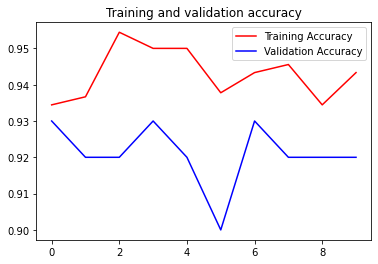

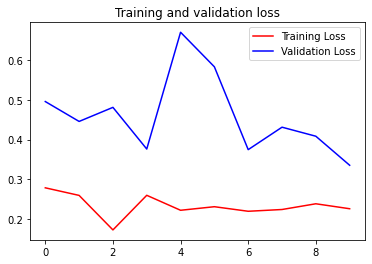

In [57]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend()
plt.title('Training and validation loss')